In [84]:
# 請先使用 transform.py 把原本的數據轉換得到 convert_shots.csv
# 接著要把不要的 feature 去掉
# 接下來再 clustering
# 這次的 cluster 加入球種 但想把發球的 shots 去掉

import pandas as pd
import sys

# load data
shots = pd.read_csv('convert_shot.csv')
match = pd.read_csv('match.csv', encoding='utf-8')
set = pd.read_csv('set.csv', encoding='utf-8')
rally = pd.read_csv('rally.csv', encoding='utf-8')
match = match[["match_id", "win_A", "win_B", "lose_C", "lose_D"]]
set = set[["set_id", "match_id"]]
rally = rally[["rally_id", "set_id"]]
shots = pd.merge(shots, rally, on='rally_id')
shots = pd.merge(shots, set, on='set_id')
shots = pd.merge(shots, match, on='match_id')
# drop feature
features = ["shot_id", "rally_id", "shot_num", "player", "ball_type", 
            "player_A_x", "player_A_y", "player_B_x", "player_B_y",
            "player_C_x", "player_C_y", "player_D_x", "player_D_y", 
            "win_A", "win_B", "lose_C", "lose_D"]
shots = shots[features]
print(shots.columns)

# extract positions in each team
shots_attack_side = pd.DataFrame()
shots_defend_side = pd.DataFrame()
rowlist_attack = []
rowlist_defend = []

# determine which player is attacking
def determine_players(row):
    if row['player'] == row['win_A']:
        hit_player_x = row['player_A_x']
        hit_player_y = row['player_A_y']
        partner_x = row['player_B_x']
        partner_y = row['player_B_y']
        defending_player1_x = row['player_C_x']
        defending_player1_y = row['player_C_y']
        defending_player2_x = row['player_D_x']
        defending_player2_y = row['player_D_y']
        attacking_team = 'A'
    elif row['player'] == row['win_B']:
        hit_player_x = row['player_B_x']
        hit_player_y = row['player_B_y']
        partner_x = row['player_A_x']
        partner_y = row['player_A_y']
        defending_player1_x = row['player_C_x']
        defending_player1_y = row['player_C_y']
        defending_player2_x = row['player_D_x']
        defending_player2_y = row['player_D_y']
        attacking_team = 'A'
    elif row['player'] == row['lose_C']:
        hit_player_x = row['player_C_x']
        hit_player_y = row['player_C_y']
        partner_x = row['player_D_x']
        partner_y = row['player_D_y']
        defending_player1_x = row['player_A_x']
        defending_player1_y = row['player_A_y']
        defending_player2_x = row['player_B_x']
        defending_player2_y = row['player_B_y']
        attacking_team = 'C'
    elif row['player'] == row['lose_D']:
        hit_player_x = row['player_D_x']
        hit_player_y = row['player_D_y']
        partner_x = row['player_C_x']
        partner_y = row['player_C_y']
        defending_player1_x = row['player_A_x']
        defending_player1_y = row['player_A_y']
        defending_player2_x = row['player_B_x']
        defending_player2_y = row['player_B_y']
        attacking_team = 'C'
    else:
        print('Error: player not found in any team')
        exit()
    return hit_player_x, hit_player_y, partner_x, partner_y, defending_player1_x, defending_player1_y, defending_player2_x, defending_player2_y, attacking_team

# iterate over each row in the shots dataframe to divide attack and defense
for _, row in shots.iterrows():
    # determine which player is attacking
    hit_player_x, hit_player_y, partner_x, partner_y, defending_player1_x, defending_player1_y, defending_player2_x, defending_player2_y, attacking_team = determine_players(row)
    
    # create a new row for team A
    new_row_A = {
        'hit_player_x': hit_player_x,
        'hit_player_y': hit_player_y,
        'partner_x': partner_x,
        'partner_y': partner_y,
        'shot_id': row['shot_id'],
        'rally_id': row['rally_id'],
        'shot_num': row['shot_num'],
        'player': row['player'],
        'ball_type': row['ball_type'],
        'attacking_team': attacking_team
    }
    
    # adjust coordinates if hit_player_y is greater than 67
    # (meaning that it is on the other side of the court)
    if new_row_A['hit_player_y'] > 67:
        new_row_A["hit_player_x"] = 61 - new_row_A["hit_player_x"]
        new_row_A["hit_player_y"] = 134 - new_row_A["hit_player_y"]
        new_row_A["partner_x"] = 61 - new_row_A["partner_x"]
        new_row_A["partner_y"] = 134 - new_row_A["partner_y"]
    # drop the row if any of the coordinates are out of bounds
    if (new_row_A['hit_player_y'] < 0 or new_row_A['partner_y'] < 0 or 
        new_row_A['hit_player_x'] < 0 or new_row_A['partner_x'] < 0 or 
        new_row_A['hit_player_y'] > 134 or new_row_A['partner_y'] > 134 or
        new_row_A['hit_player_x'] > 61 or new_row_A['partner_x'] > 61):
        pass
    else:
        rowlist_attack.append(new_row_A)
    
    # create a new row for team C
    new_row_C = {
        'player1_x': defending_player1_x,
        'player1_y': defending_player1_y,
        'player2_x': defending_player2_x,
        'player2_y': defending_player2_y,
        'shot_id': row['shot_id'],
        'rally_id': row['rally_id'],
        'shot_num': row['shot_num'],
        'player': row['player'],
        'ball_type': row['ball_type'],
    }
    # adjust coordinates if player1_y is greater than 67 
    # (meaning that it is on the other side of the court)
    if new_row_C['player1_y'] > 67:
        new_row_C["player1_x"] = 61 - new_row_C["player1_x"]
        new_row_C["player1_y"] = 134 - new_row_C["player1_y"]
        new_row_C["player2_x"] = 61 - new_row_C["player2_x"]
        new_row_C["player2_y"] = 134 - new_row_C["player2_y"]
    # drop the row if any of the coordinates are out of bounds
    if (new_row_C['player1_y'] < 0 or new_row_C['player2_y'] < 0 or 
        new_row_C['player1_x'] < 0 or new_row_C['player2_x'] < 0 or 
        new_row_C['player1_y'] > 134 or new_row_C['player2_y'] > 134 or
        new_row_C['player1_x'] > 61 or new_row_C['player2_x'] > 61):
        pass
    else: 
        rowlist_defend.append(new_row_C)
    
shots_attack_side = pd.DataFrame(rowlist_attack)
shots_defend_side = pd.DataFrame(rowlist_defend)
# print(shots_attack_side)
# print(shots_defend_side)


Index(['shot_id', 'rally_id', 'shot_num', 'player', 'ball_type', 'player_A_x',
       'player_A_y', 'player_B_x', 'player_B_y', 'player_C_x', 'player_C_y',
       'player_D_x', 'player_D_y', 'win_A', 'win_B', 'lose_C', 'lose_D'],
      dtype='object')


In [85]:
# normalize the positions
shots_attack_side['hit_player_x_norm'] = ( (shots_attack_side['hit_player_x'] - shots_attack_side['hit_player_x'].min()) / 
                                    (shots_attack_side['hit_player_x'].max() - shots_attack_side['hit_player_x'].min()) )
shots_attack_side['hit_player_y_norm'] = ( (shots_attack_side['hit_player_y'] - shots_attack_side['hit_player_y'].min()) /
                                    (shots_attack_side['hit_player_y'].max() - shots_attack_side['hit_player_y'].min()) )
shots_attack_side['partner_x_norm'] = ( (shots_attack_side['partner_x'] - shots_attack_side['partner_x'].min()) /
                                    (shots_attack_side['partner_x'].max() - shots_attack_side['partner_x'].min()) )
shots_attack_side['partner_y_norm'] = ( (shots_attack_side['partner_y'] - shots_attack_side['partner_y'].min()) /
                                    (shots_attack_side['partner_y'].max() - shots_attack_side['partner_y'].min()) )

shots_defend_side['player1_x_norm'] = ( (shots_defend_side['player1_x'] - shots_defend_side['player1_x'].min()) / 
                                    (shots_defend_side['player1_x'].max() - shots_defend_side['player1_x'].min()) )
shots_defend_side['player1_y_norm'] = ( (shots_defend_side['player1_y'] - shots_defend_side['player1_y'].min()) /
                                    (shots_defend_side['player1_y'].max() - shots_defend_side['player1_y'].min()) )
shots_defend_side['player2_x_norm'] = ( (shots_defend_side['player2_x'] - shots_defend_side['player2_x'].min()) /
                                    (shots_defend_side['player2_x'].max() - shots_defend_side['player2_x'].min()) )
shots_defend_side['player2_y_norm'] = ( (shots_defend_side['player2_y'] - shots_defend_side['player2_y'].min()) /
                                    (shots_defend_side['player2_y'].max() - shots_defend_side['player2_y'].min()) )

# use -1 to 0 to represent the ball type
mapping = {
    '過度切球': '切球',
    '防守回抽': '平球',
    '後場抽平球': '平球',
    '防守回挑': '挑球',
    '推球': '推撲球',
    '撲球': '推撲球',
    '擋小球': '網前小球',
    '勾球': '網前小球',
    '放小球': '網前小球',
    '小平球': '網前小球'
}
shots_defend_side['ball_type'] = shots_defend_side['ball_type'].replace(mapping)
shots_attack_side['ball_type'] = shots_attack_side['ball_type'].replace(mapping)
# drop those ball types that is serving
shots_defend_side = shots_defend_side[shots_defend_side['ball_type'] != '發長球']
shots_defend_side = shots_defend_side[shots_defend_side['ball_type'] != '發短球']
shots_attack_side = shots_attack_side[shots_attack_side['ball_type'] != '發長球']
shots_attack_side = shots_attack_side[shots_attack_side['ball_type'] != '發短球']
# use -1 to 0 to represent the ball type
mapping = {
    '殺球' : -1,
    '推撲球' : -0.8333333333,
    '平球' : -0.6666666666,
    '切球' : -0.5,
    '長球' : -0.3333333333,
    '挑球' : -0.1666666666,
    '網前小球' : 0
}
shots_attack_side['ball_type'] = shots_attack_side['ball_type'].replace(mapping)
shots_defend_side['ball_type'] = shots_defend_side['ball_type'].replace(mapping)

print("shots_attack_side: " + str(shots_attack_side.shape))
print("shots_defend_side: " + str(shots_defend_side.shape))


shots_attack_side: (29730, 14)
shots_defend_side: (29729, 13)


c:\Users\vito\anaconda3\envs\for_sklearn\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


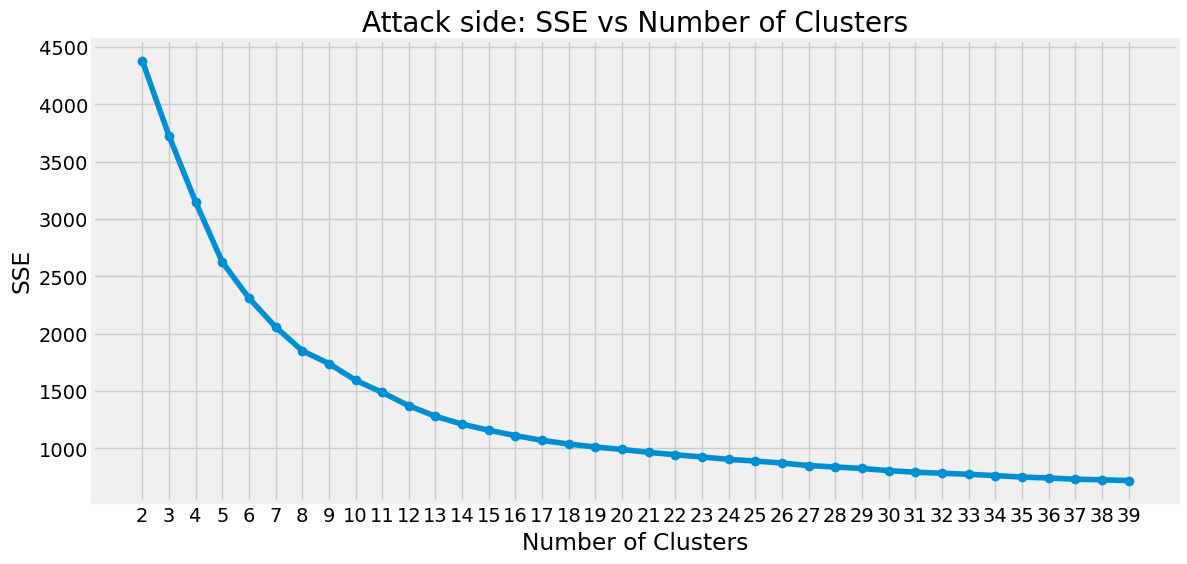

In [ ]:
# using elbow method to find the optimal k
# we do attack side first
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# Prepare data for clustering
select_columns = ['hit_player_x_norm', 'hit_player_y_norm', 'partner_x_norm', 'partner_y_norm', 'ball_type']
shots_attack_side = shots_attack_side.dropna(subset=select_columns)
X = shots_attack_side[select_columns]

sse = []
silhouette_scores = []
for k in range(2, 40):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 40), sse, marker='o')
plt.xticks(range(2, 40))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Attack side: SSE vs Number of Clusters")
plt.show()

In [23]:
# using silhouette score to find the optimal k
# same, we do attack side first

from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter

# sample before silhouette score since it takes a long time
# use StratifiedShuffleSplit to sample
select_columns = ['hit_player_x_norm', 'hit_player_y_norm', 'partner_x_norm', 'partner_y_norm', 'ball_type']
df = shots_attack_side[select_columns]
y = df['ball_type']
X = df.drop(columns=['ball_type'])
# Create StratifiedShuffleSplit instance
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get stratified split for the sampled dataset
for train_index, test_index in splitter.split(X, y):
    X_sample = X.iloc[test_index]
    y_sample = y.iloc[test_index]

# Create a new DataFrame for the sampled data
sample = X_sample.copy()
sample['ball_type'] = y_sample

# Check the distribution before and after sampling
print("Original ball_type distribution:", Counter(y))
print("Sampled ball_type distribution:", Counter(y_sample))
print("Sampled data shape:", sample.shape)

silhouette_scores = []
for k in range(2, 40):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(sample)
    lables = kmeans.labels_
    score = silhouette_score(sample, lables)
    silhouette_scores.append(score)

plt.figure(figsize=(14, 6))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 40), silhouette_scores, marker='o')
plt.xticks(range(2, 40))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title("Attack side: Silhouette Score vs Number of Clusters")
plt.show()

Original ball_type distribution: Counter({-0.16666666666666666: 7305, 0.0: 5804, -1.0: 5769, -0.6666666666: 4275, -0.5: 2430, -0.8333333333: 2194, -0.3333333333333333: 1930})
Sampled ball_type distribution: Counter({-0.16666666666666666: 1461, 0.0: 1161, -1.0: 1154, -0.6666666666: 855, -0.5: 486, -0.8333333333: 439, -0.3333333333333333: 386})
Sampled data shape: (5942, 5)


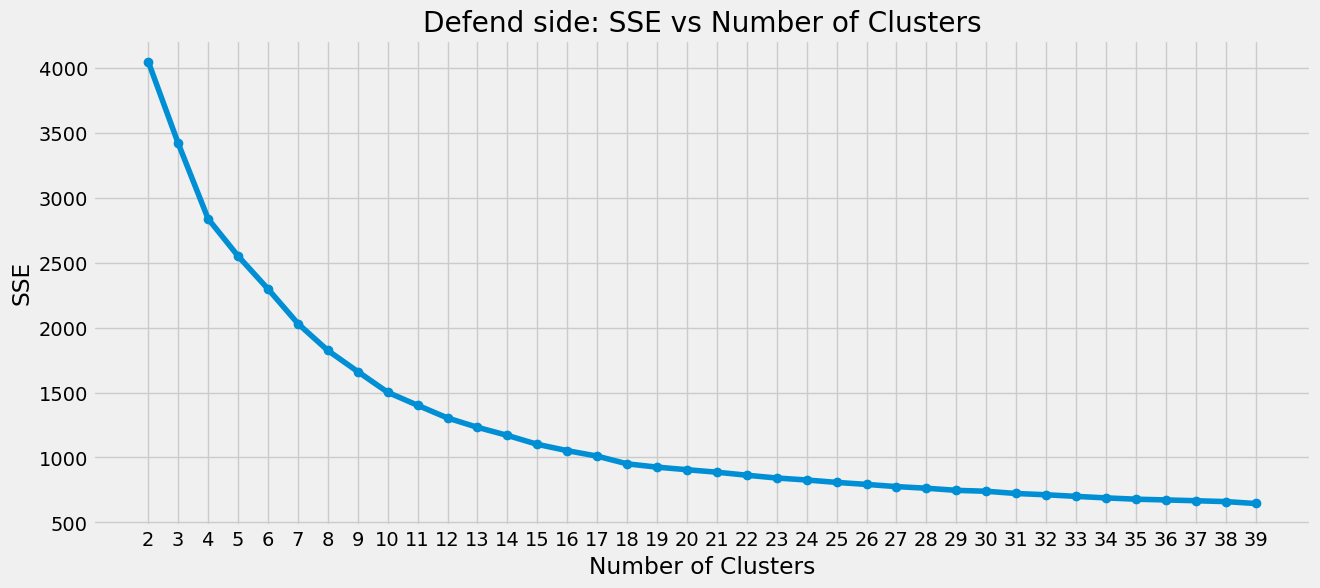

In [16]:
# using elbow method to find the optimal k
# we do defend side now
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# Prepare data for clustering
select_columns = ['player1_x_norm', 'player1_y_norm', 'player2_x_norm', 'player2_y_norm', 'ball_type']
shots_defend_side = shots_defend_side.dropna(subset=select_columns)
X = shots_defend_side[select_columns]

sse = []
silhouette_scores = []
for k in range(2, 40):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 40), sse, marker='o')
plt.xticks(range(2, 40))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Defend side: SSE vs Number of Clusters")
plt.show()

In [ ]:
# using silhouette score to find the optimal k
# we do defend side now

# sample before silhouette score since it takes a long time
# use StratifiedShuffleSplit to sample so that the distribution of balltype is maintained
# prepare data
select_columns = ['player1_x_norm', 'player1_y_norm', 'player2_x_norm', 'player2_y_norm', 'ball_type']
df = shots_defend_side[select_columns]
y = df['ball_type']
X = df.drop(columns=['ball_type'])

# Create StratifiedShuffleSplit instance
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get stratified split for the sampled dataset
for train_index, test_index in splitter.split(X, y):
    X_sample = X.iloc[test_index]
    y_sample = y.iloc[test_index]

# Create a new DataFrame for the sampled data
sample = X_sample.copy()
sample['ball_type'] = y_sample

# Check the distribution before and after sampling
print("Original ball_type distribution:", Counter(y))
print("Sampled ball_type distribution:", Counter(y_sample))
print("Sampled data shape:", sample.shape)

silhouette_scores = []
for k in range(2, 40):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(sample)
    lables = kmeans.labels_
    score = silhouette_score(sample, lables)
    silhouette_scores.append(score)

plt.figure(figsize=(14, 6))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 40), silhouette_scores, marker='o')
plt.xticks(range(2, 40))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title("defend side: Silhouette Score vs Number of Clusters")
plt.show()

Original ball_type distribution: Counter({-0.16666666666666666: 7289, 0.0: 5800, -1.0: 5789, -0.6666666666: 4256, -0.5: 2439, -0.8333333333: 2195, -0.3333333333333333: 1939})
Sampled ball_type distribution: Counter({-0.16666666666666666: 1458, 0.0: 1160, -1.0: 1158, -0.6666666666: 851, -0.5: 488, -0.8333333333: 439, -0.3333333333333333: 388})


In [86]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Start clustering
# same, we do attack side first
n = 16  # Number of clusters
select_columns = ['hit_player_x_norm', 'hit_player_y_norm', 'partner_x_norm', 'partner_y_norm', 'ball_type']
shots_attack_side = shots_attack_side.dropna(subset=select_columns)
X = shots_attack_side[select_columns]

kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
kmeans.fit(X)
shots_attack_side['cluster'] = kmeans.fit_predict(X)
cluster_counts = shots_attack_side['cluster'].value_counts()
print(shots_attack_side.shape)

print(cluster_counts)

mapping = {
    -1 : '殺球',
    -0.8333333333 : '推撲球',
    -0.6666666666 : '平球',
    -0.5 : '切球',
    -0.3333333333 : '長球',
    -0.1666666666 : '挑球',
    0 : '網前小球'
}
shots_attack_side['ball_type'] = shots_attack_side['ball_type'].replace(mapping)

balltype_crosstab = pd.crosstab(shots_attack_side['cluster'], shots_attack_side['ball_type'])
print(balltype_crosstab)



(29707, 15)
cluster
3     3017
2     2606
9     2342
0     2341
7     2163
13    2038
5     1942
11    1890
1     1704
15    1602
12    1514
14    1494
10    1415
6     1262
4     1191
8     1186
Name: count, dtype: int64
ball_type    切球    平球    挑球   推撲球    殺球  網前小球   長球
cluster                                           
0             0     0  1468     0     0   767  106
1            85  1501     0    67    51     0    0
2             0     0  1636     0     0   889   81
3             0     0     0     9  3008     0    0
4             0     0   435     0     0   747    9
5             0     0  1425     0     0   498   19
6             8   212     0   853   189     0    0
7             0     0     0     7  2156     0    0
8            75   961     0    76    74     0    0
9             0     0  1466     0     0   859   17
10           56  1254     0    84    21     0    0
11         1054    83    10     0     0     0  743
12            0     0   267     0     0  1244    3
13         11

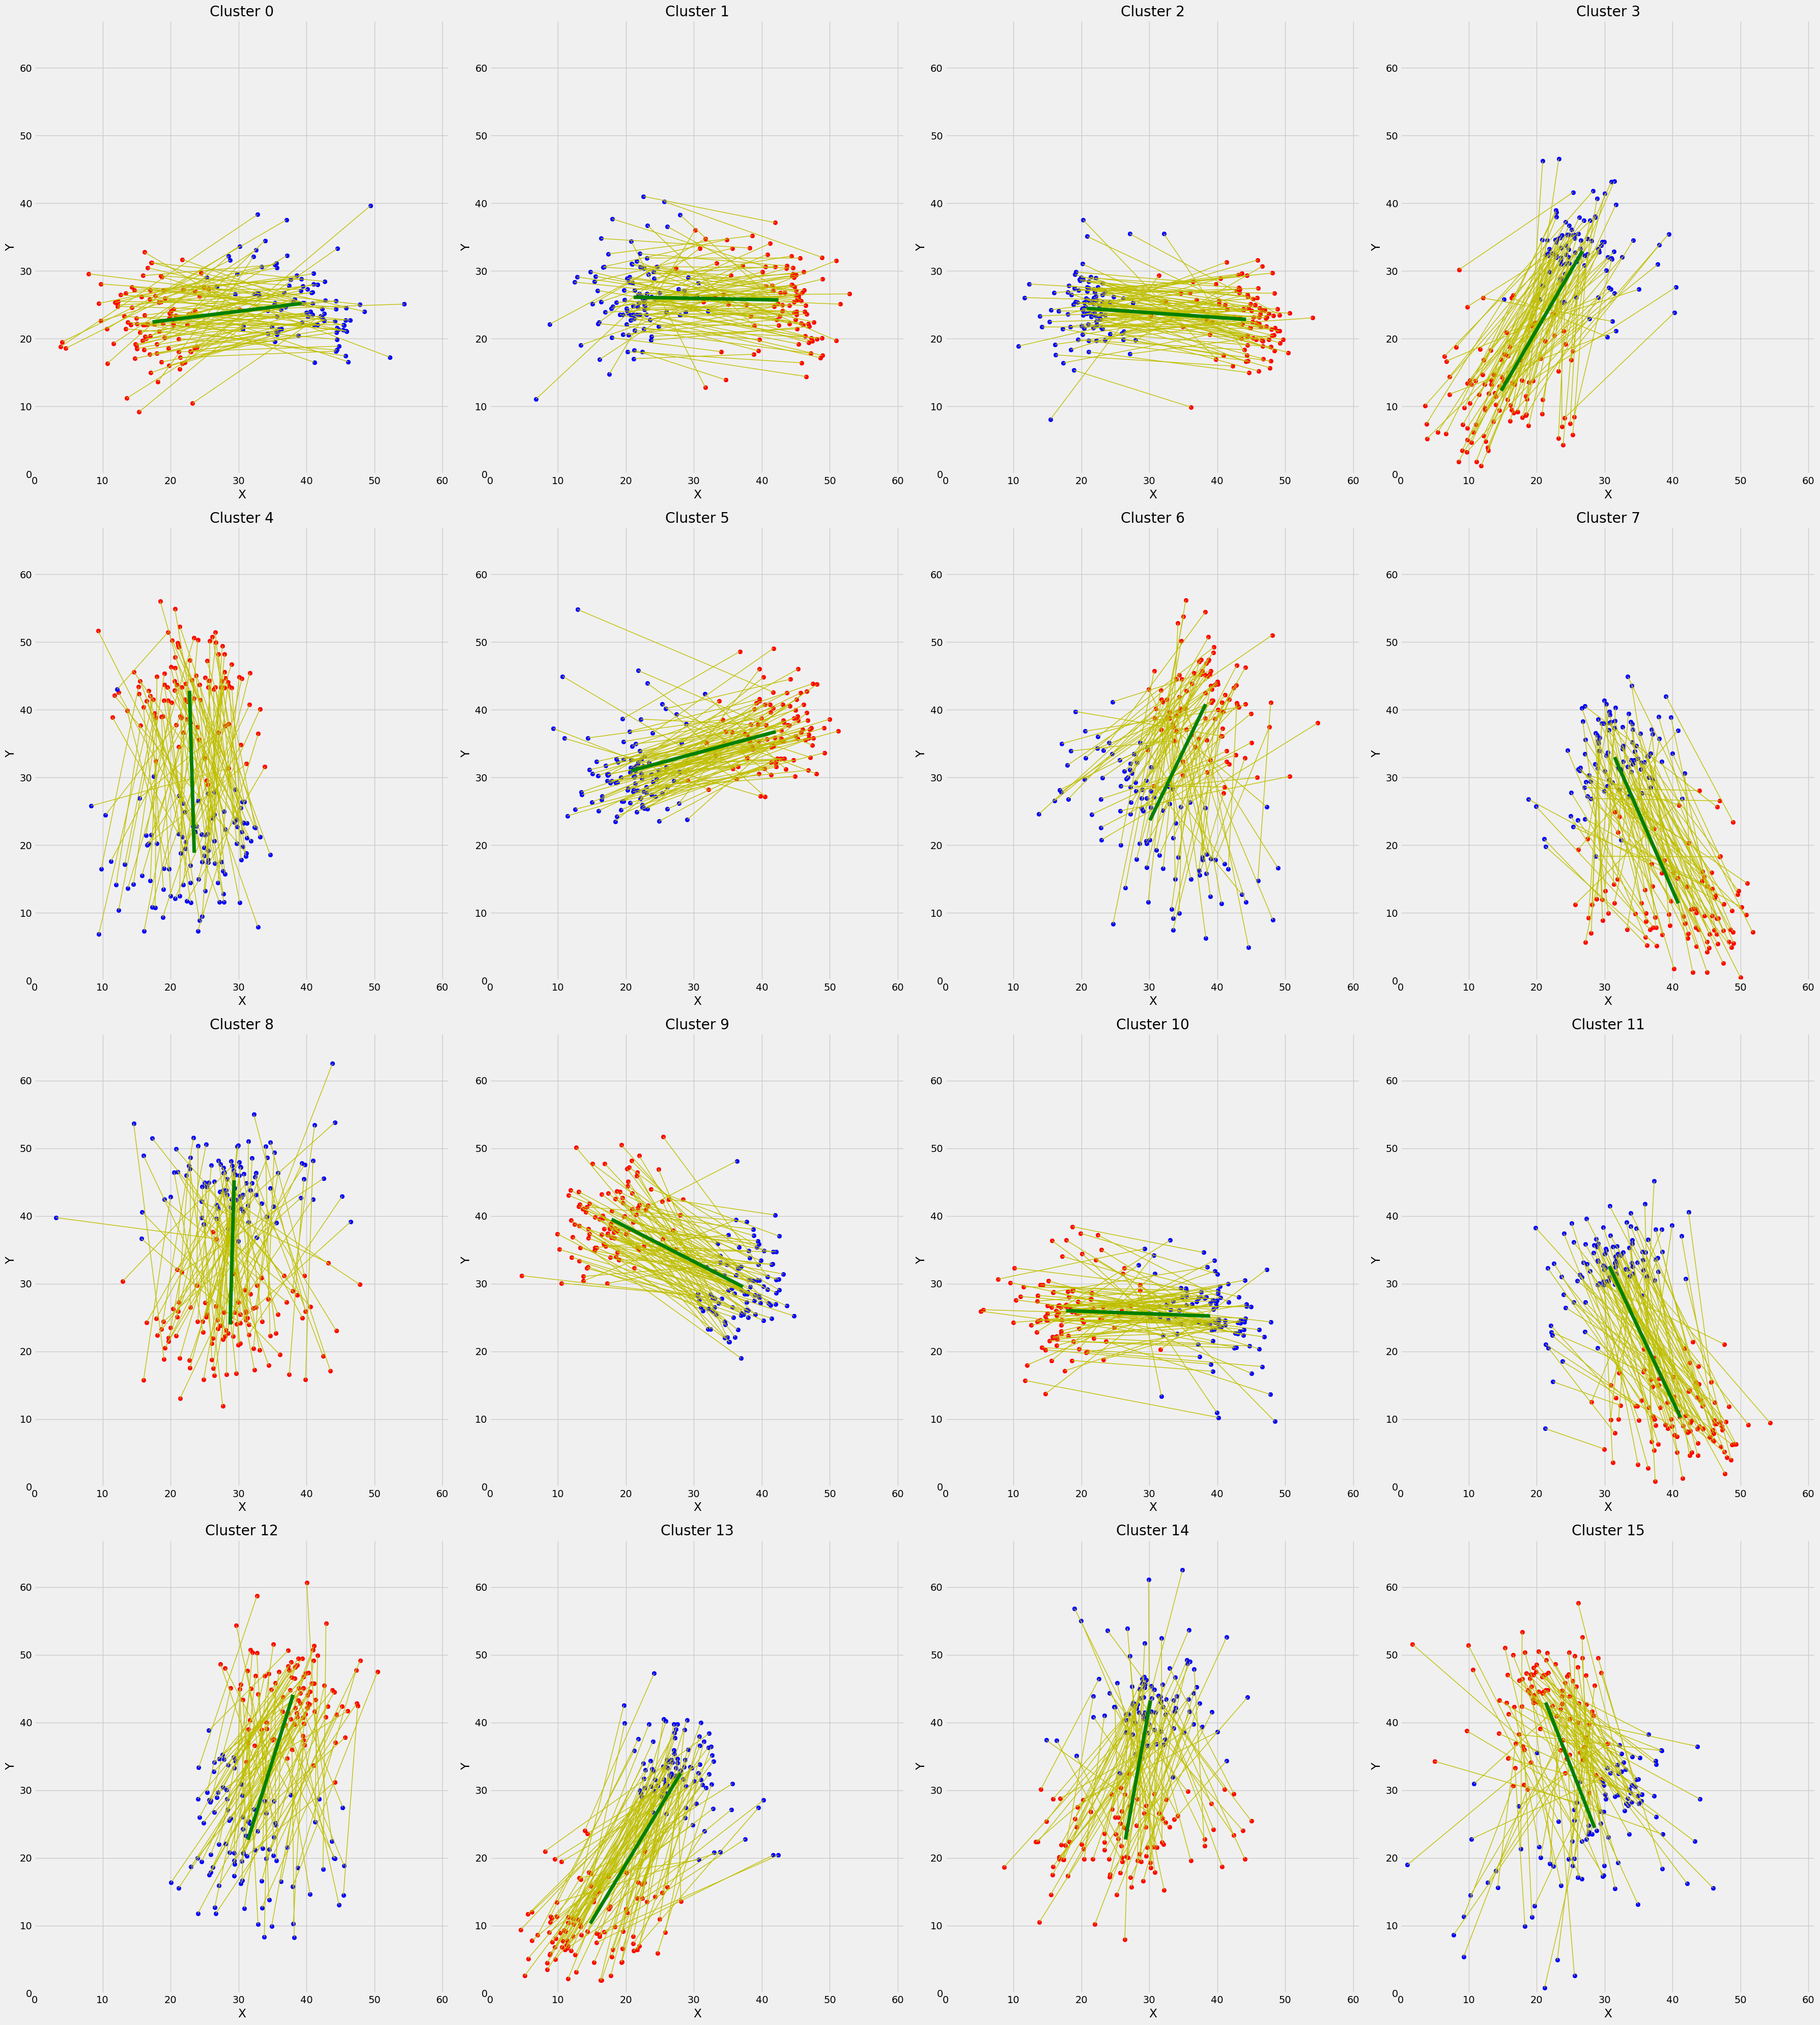

In [89]:
# Create a figure with subplots
# do attack side first
fig, axes = plt.subplots(4, 4, figsize=(36, 40))
axes = axes.flatten()  # Flatten to make iteration easier

# initialize the save directory
import os
if not os.path.exists('attack'):
    os.makedirs('attack')


for cluster in range(0, n):
    ax = axes[cluster]  # Select the subplot axis
    cluster_data = shots_attack_side[shots_attack_side['cluster'] == cluster]
    # If more than 100 points, sample data
    if len(cluster_data) > 100:
        sample_data = cluster_data.sample(n=100, random_state=41)
    else:
        sample_data = cluster_data

    # Plot Player 1
    ax.scatter(sample_data['hit_player_x'], sample_data['hit_player_y'], color='r', label=f'Cluster {cluster} - Player 1')
    # Plot partner line
    ax.plot([sample_data['hit_player_x'], sample_data['partner_x']], 
             [sample_data['hit_player_y'], sample_data['partner_y']], color='y', label=f'Cluster {cluster} - partner line', linewidth=1)
    # Plot Player 2
    ax.scatter(sample_data['partner_x'], sample_data['partner_y'], color='b', label=f'Cluster {cluster} - Player 2')
    # Plot center line
    ax.plot([sample_data['partner_x'].mean(), sample_data['hit_player_x'].mean()],
            [sample_data['partner_y'].mean(), sample_data['hit_player_y'].mean()], 
            color='g', label=f'Cluster {cluster} - center line', linewidth=5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(0, 61)
    ax.set_ylim(0, 67)
    ax.set_title(f'Cluster {cluster}')

    # Save each subplot as an individual figure
    individual_fig = plt.figure(figsize=(9.15, 10.05))
    plt.scatter(sample_data['hit_player_x'], sample_data['hit_player_y'], color='r', label=f'Cluster {cluster} - Player 1')
    plt.plot([sample_data['hit_player_x'], sample_data['partner_x']], 
             [sample_data['hit_player_y'], sample_data['partner_y']], color='y', label=f'Cluster {cluster} - partner line', linewidth=1)
    plt.scatter(sample_data['partner_x'], sample_data['partner_y'], color='b', label=f'Cluster {cluster} - Player 2')
    plt.plot([sample_data['partner_x'].mean(), sample_data['hit_player_x'].mean()],
             [sample_data['partner_y'].mean(), sample_data['hit_player_y'].mean()], 
             color='g', label=f'Cluster {cluster} - center line', linewidth=5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(0, 61)
    plt.ylim(0, 67)
    plt.title(f'Cluster {cluster}')
    plt.savefig(f'attack/cluster{cluster}.jpg')
    plt.close(individual_fig)  # Close the individual figure after saving

# Adjust layout so the subplots don't overlap
plt.tight_layout()
# Save the entire figure
plt.savefig('all_clusters.jpg')
# Show the plot
plt.show()



In [91]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Start clustering
# we do defend side now
n = 16  # Number of clusters
select_columns = ['player1_x_norm', 'player1_y_norm', 'player2_x_norm', 'player2_y_norm', 'ball_type']
shots_defend_side = shots_defend_side.dropna(subset=select_columns)
X = shots_defend_side[select_columns]

kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
kmeans.fit(X)
shots_defend_side['cluster'] = kmeans.fit_predict(X)
cluster_counts = shots_defend_side['cluster'].value_counts()
print(shots_defend_side.columns)

print(cluster_counts)

mapping = {
    -1 : '殺球',
    -0.8333333333 : '推撲球',
    -0.6666666666 : '平球',
    -0.5 : '切球',
    -0.3333333333 : '長球',
    -0.1666666666 : '挑球',
    0 : '網前小球'
}
shots_defend_side['ball_type'] = shots_defend_side['ball_type'].replace(mapping)

balltype_crosstab = pd.crosstab(shots_defend_side['cluster'], shots_defend_side['ball_type'])
print(balltype_crosstab)



Index(['player1_x', 'player1_y', 'player2_x', 'player2_y', 'shot_id',
       'rally_id', 'shot_num', 'player', 'ball_type', 'player1_x_norm',
       'player1_y_norm', 'player2_x_norm', 'player2_y_norm', 'cluster'],
      dtype='object')
cluster
3     3152
1     3122
12    2449
4     2407
6     2392
8     2096
7     2093
10    1753
0     1676
14    1567
13    1551
2     1453
11    1269
9     1260
15     807
5      660
Name: count, dtype: int64
ball_type    切球    平球    挑球  推撲球    殺球  網前小球   長球
cluster                                          
0             0     0  1252    0     0   411   13
1             0     0     0  272  2850     0    0
2             0     0   416    0     0  1037    0
3             0     0     0  317  2835     0    0
4             0     0   995    0     0  1349   63
5             7   552     0   96     5     0    0
6          1159   332     0    0     0     0  901
7             0     0  1030    0     0   987   76
8            27  1262     0  747    60     0    0
9  

C:\Users\vito\AppData\Local\Temp\ipykernel_34056\2036249095.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots_defend_side['cluster'] = kmeans.fit_predict(X)
C:\Users\vito\AppData\Local\Temp\ipykernel_34056\2036249095.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots_defend_side['ball_type'] = shots_defend_side['ball_type'].replace(mapping)


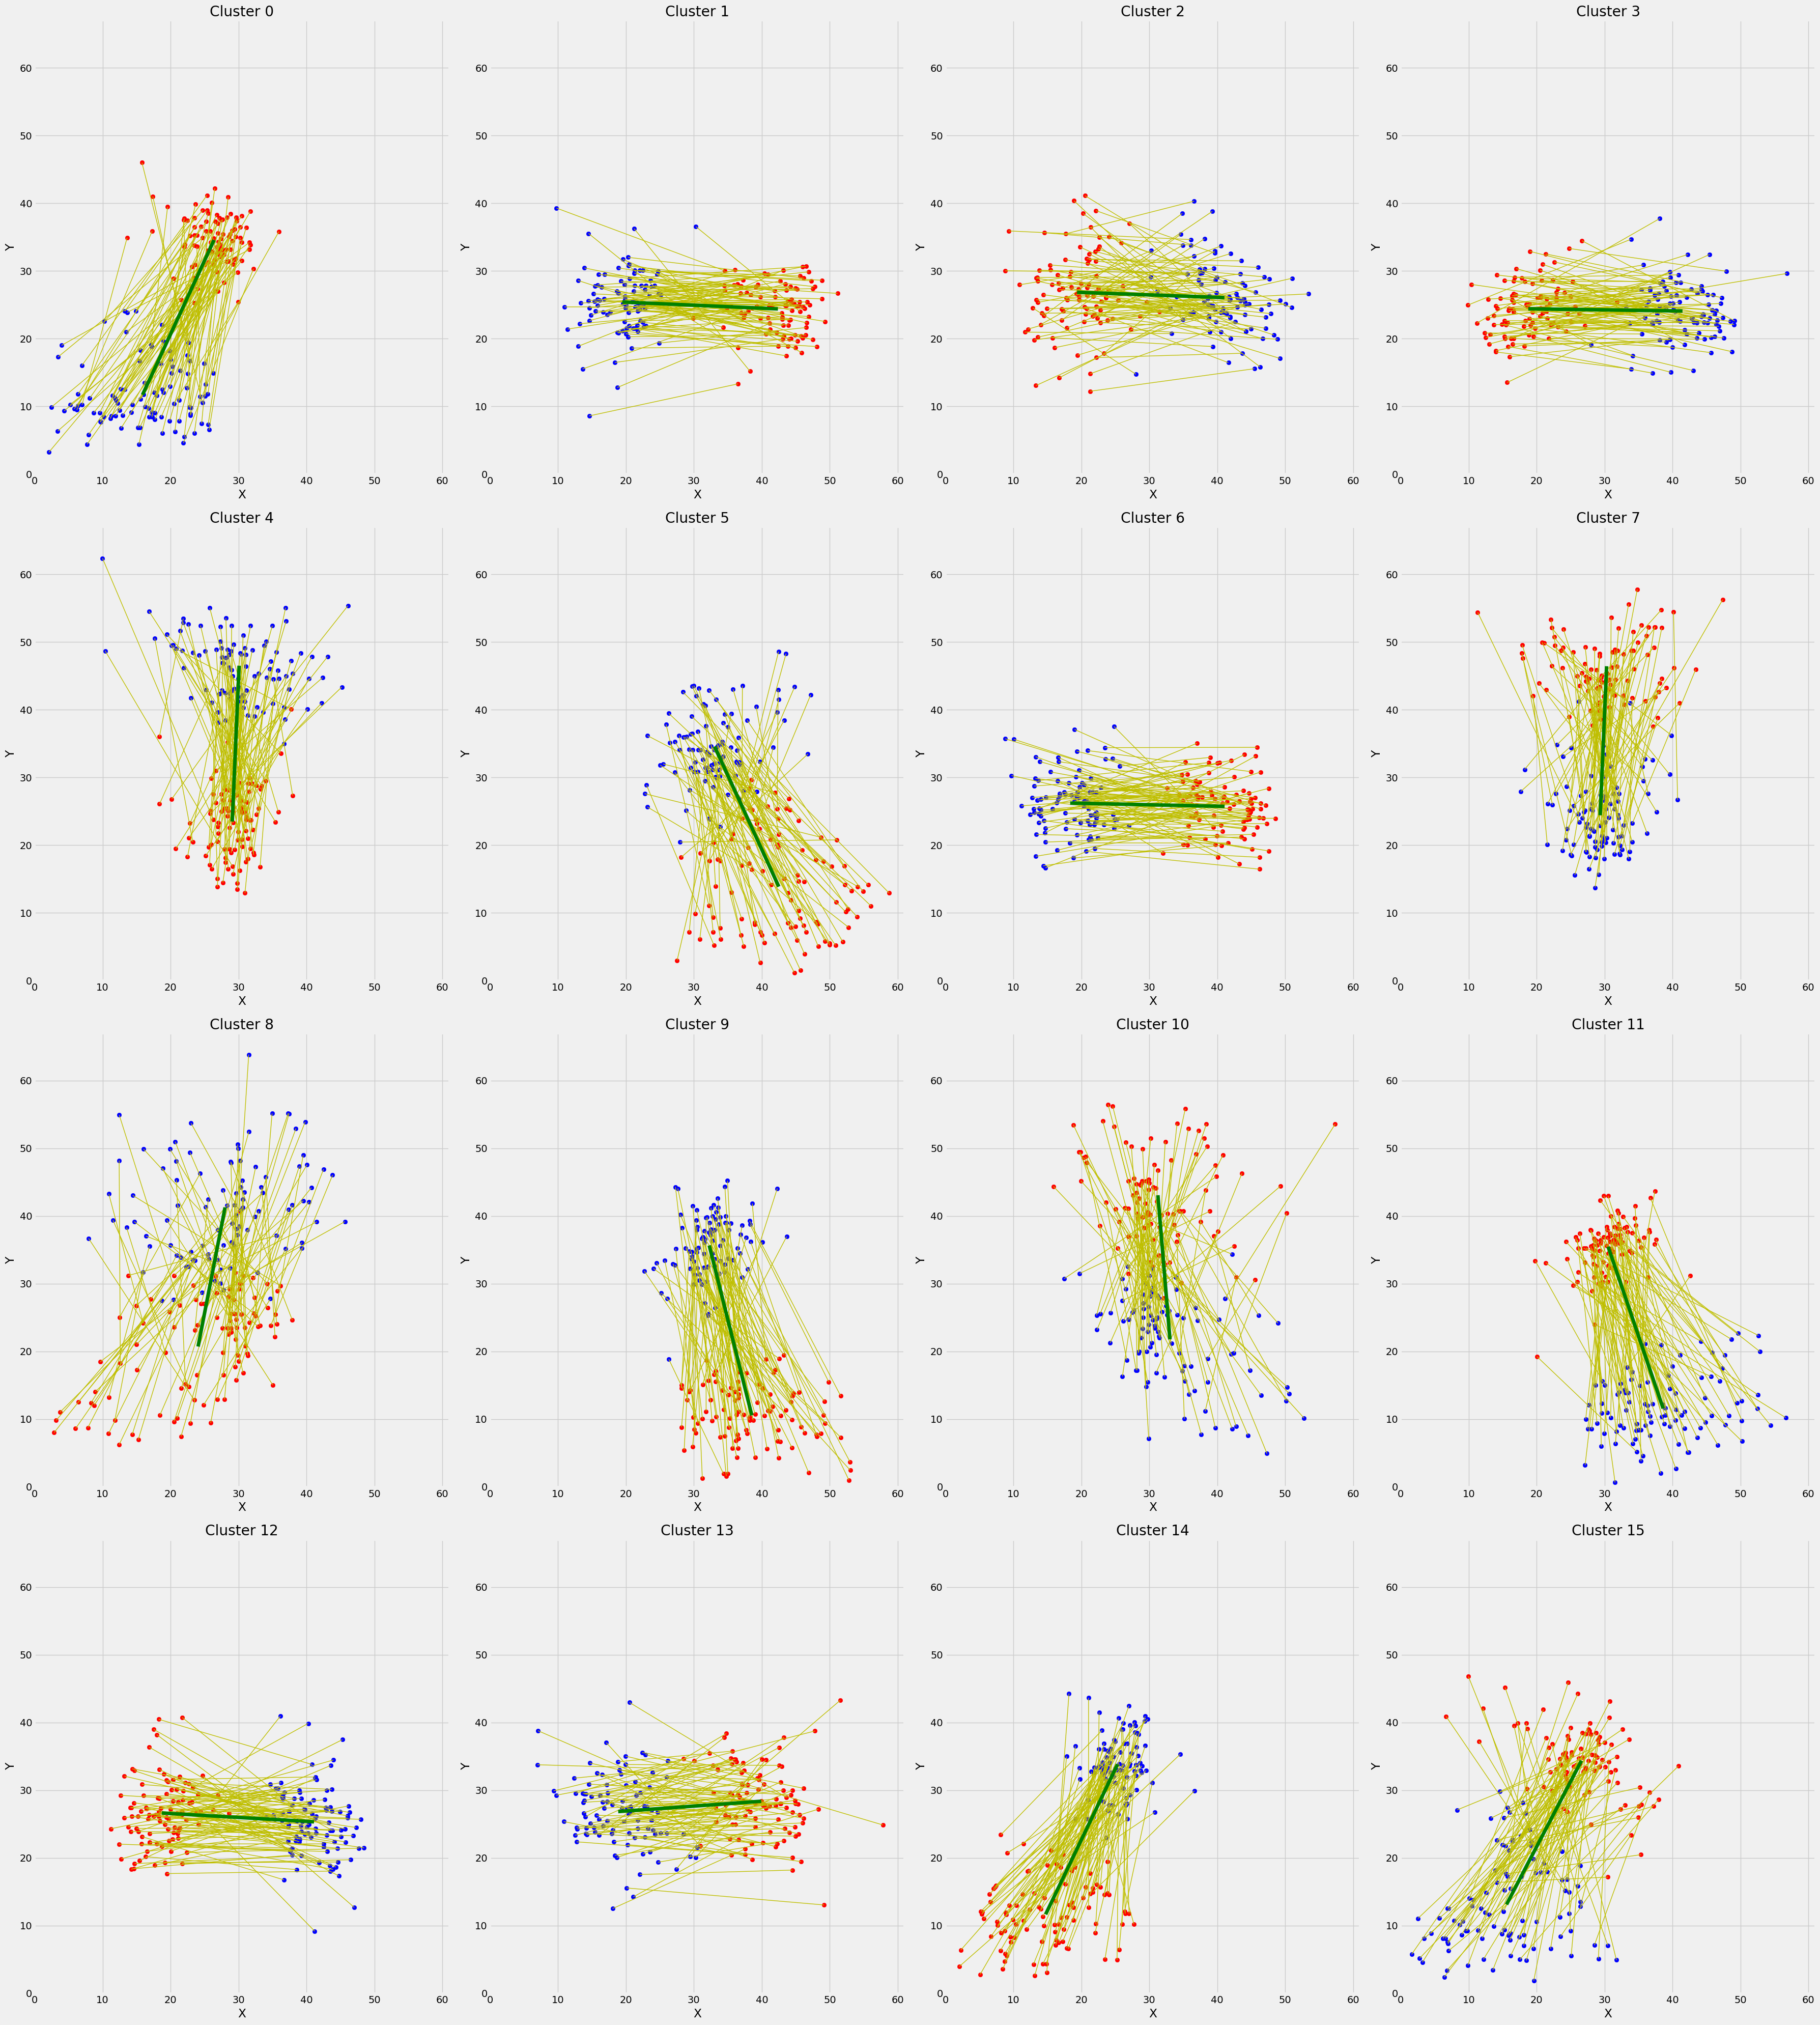

In [92]:
# Create a figure with subplots
# do defend side now
fig, axes = plt.subplots(4, 4, figsize=(36, 40))
axes = axes.flatten()  # Flatten to make iteration easier

# initialize the save directory
import os
if not os.path.exists('defend'):
    os.makedirs('defend')

for cluster in range(0, n):
    ax = axes[cluster]  # Select the subplot axis
    cluster_data = shots_defend_side[shots_defend_side['cluster'] == cluster]
    # If more than 100 points, sample data
    if len(cluster_data) > 100:
        sample_data = cluster_data.sample(n=100, random_state=41)
    else:
        sample_data = cluster_data

    # Plot Player 1
    ax.scatter(sample_data['player1_x'], sample_data['player1_y'], color='r', label=f'Cluster {cluster} - Player 1')
    # Plot partner line
    ax.plot([sample_data['player1_x'], sample_data['player2_x']], 
             [sample_data['player1_y'], sample_data['player2_y']], color='y', label=f'Cluster {cluster} - partner line', linewidth=1)
    # Plot Player 2
    ax.scatter(sample_data['player2_x'], sample_data['player2_y'], color='b', label=f'Cluster {cluster} - Player 2')
    # Plot center line
    ax.plot([sample_data['player2_x'].mean(), sample_data['player1_x'].mean()],
            [sample_data['player2_y'].mean(), sample_data['player1_y'].mean()], 
            color='g', label=f'Cluster {cluster} - center line', linewidth=5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(0, 61)
    ax.set_ylim(0, 67)
    ax.set_title(f'Cluster {cluster}')

    # Save each subplot as an individual figure
    individual_fig = plt.figure(figsize=(9.15, 10.05))
    plt.scatter(sample_data['player1_x'], sample_data['player1_y'], color='r', label=f'Cluster {cluster} - Player 1')
    plt.plot([sample_data['player1_x'], sample_data['player2_x']], 
             [sample_data['player1_y'], sample_data['player2_y']], color='y', label=f'Cluster {cluster} - partner line', linewidth=1)
    plt.scatter(sample_data['player2_x'], sample_data['player2_y'], color='b', label=f'Cluster {cluster} - Player 2')
    plt.plot([sample_data['player2_x'].mean(), sample_data['player1_x'].mean()],
             [sample_data['player2_y'].mean(), sample_data['player1_y'].mean()], 
             color='g', label=f'Cluster {cluster} - center line', linewidth=5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(0, 61)
    plt.ylim(0, 67)
    plt.title(f'Cluster {cluster}')
    plt.savefig(f'defend/cluster{cluster}.jpg')
    plt.close(individual_fig)  # Close the individual figure after saving

# Adjust layout so the subplots don't overlap
plt.tight_layout()
# Save the entire figure
plt.savefig('all_clusters.jpg')
# Show the plot
plt.show()



In [75]:
# statistics, to know which cluster is more likely to score
# first, put the cluster information back to the original dataframe
shots_defend_side["def_cluster"] = shots_defend_side["cluster"]
shots_defend_side_ = shots_defend_side[["shot_id", "def_cluster", "player1_x", "player1_y", "player2_x", "player2_y"]]
shots_attack_side["attack_cluster"] = shots_attack_side["cluster"]
shots_attack_side_ = shots_attack_side.drop(columns=["cluster"])
shots_2side = pd.merge(shots_attack_side_, shots_defend_side_, on = "shot_id", how = "inner")

# shots_pivot = shots_2side[["shot_id", "team", "cluster"]]
# shots_pivot = shots_2side.pivot(index = 'shot_id', columns = 'team', values = 'cluster')
# shots_pivot = shots_pivot.reset_index()
# shots_pivot.columns = ["shot_id", "team_A_cluster", "team_C_cluster"]
# shots_with_cluster = pd.merge(shots, shots_pivot, on = "shot_id", how = "left")
# # get the last shot of each rally
last_shot = shots_2side.groupby("rally_id").last().reset_index()

# then get the team information of each rally
rally = pd.read_csv('rally.csv')
rally = rally[["rally_id", "set_id", "serve_player", "score_team", "score_reason"]]
rally.drop(rally[rally["score_reason"] != "落地致勝"].index, inplace = True)
set = pd.read_csv('set.csv')
set = set[["set_id", "match_id"]]
match = pd.read_csv('match.csv')
match = match[["match_id", "win_A", "win_B", "lose_C", "lose_D"]]
rally = pd.merge(rally, set, on = "set_id", how = "inner")
rally = pd.merge(rally, match, on = "match_id", how = "inner")

# since the team information is not in the rally dataframe, we need to infer it from the serve player
current_set = -1
team0 = ""
team1 = ""
# print(rally)
for index, row in rally.iterrows():
    # for each set, get which team is 0 and 1 (in the score_team column)
    if current_set != row["set_id"]:
        current_set = row["set_id"]
        if index+1 < len(rally):
            next_row = rally.iloc[index+1]
        else:
            print("error")
            sys.exit(1)
        if next_row["serve_player"] == row["win_A"] or next_row["serve_player"] == row["win_B"]:
            team0 = 'A' if row["score_team"] == 0 else 'C'
            team1 = 'C' if row["score_team"] == 0 else 'A'
        else:
            team0 = 'C' if row["score_team"] == 0 else 'A'
            team1 = 'A' if row["score_team"] == 0 else 'C'
    rally.at[index, "team0"] = team0
    rally.at[index, "team1"] = team1

# now we get which team is winning in each rally
# then we can get the cluster information of the winning team and losing team
shots_with_rally = pd.merge(last_shot, rally, on = "rally_id", how = "inner")
# print(shots_with_rally)

# actually, i think the data is kinda off
# because some of the attacking team in the last shot is not the same as the scoring team
# right now, i will use the attack cluster as the scoring cluster
# but i dont think it is correct.
def get_scoring_cluster(row):
    if row["score_team"] == 0: # team0 is the winning team
        if row["team0"] == 'A' and row["attacking_team"] != 'A':
            # print("the attacking team is not the same as scoring team.")
            return row["attack_cluster"]
        elif row["team0"] == 'C' and row["attacking_team"] != 'C':
            # print("the attacking team is not the same as scoring team.")
            return row["attack_cluster"]
    elif row["score_team"] == 1: # team1 is the winning team
        if row["team1"] == 'A' and row["attacking_team"] != 'A':
            # print("the attacking team is not the same as scoring team.")
            return row["attack_cluster"]
        elif row["team1"] == 'C' and row["attacking_team"] != 'C':
            # print("the attacking team is not the same as scoring team.")
            return row["attack_cluster"]
    return row["attack_cluster"]
def get_losing_cluster(row):
    return row["def_cluster"]
    
shots_with_rally["scoring_cluster"] = shots_with_rally.apply(get_scoring_cluster, axis = 1)
shots_with_rally["losing_cluster"] = shots_with_rally.apply(get_losing_cluster, axis = 1)

# finally, we can get the statistics
# Count the number of times each cluster scores
scoring_cluster_counts = shots_with_rally["scoring_cluster"].value_counts()
# Count the number of times each cluster loses
losing_cluster_counts = shots_with_rally["losing_cluster"].value_counts()
# Convert the scoring counts to a DataFrame
scoring_cluster_counts_df = scoring_cluster_counts.reset_index()
scoring_cluster_counts_df.columns = ["cluster", "scoring"]
# Convert the losing counts to a DataFrame
losing_cluster_counts_df = losing_cluster_counts.reset_index()
losing_cluster_counts_df.columns = ["cluster", "losing"]

# Merge the scoring and losing counts DataFrames
cluster_counts_df = pd.merge(scoring_cluster_counts_df, losing_cluster_counts_df, on="cluster", how="outer")
print("total scoring shots: " + str(cluster_counts_df["scoring"].sum()))
print("total losing shots: " + str(cluster_counts_df["losing"].sum()))
print(cluster_counts_df)
cluster_counts_df.sort_values(by = "losing", ascending = False, inplace = True)
print(cluster_counts_df)




total scoring shots: 642
total losing shots: 642
    cluster  scoring  losing
0        15      153      29
1         6      126      18
2         7       57      26
3         3       49     144
4         8       42      94
5        12       39      22
6        10       30      64
7         1       26     125
8         4       20      33
9         9       19       6
10       14       18       8
11        2       16      21
12       11       15       7
13       13       12      23
14        0       11       8
15        5        9      14
    cluster  scoring  losing
3         3       49     144
7         1       26     125
4         8       42      94
6        10       30      64
8         4       20      33
0        15      153      29
2         7       57      26
13       13       12      23
5        12       39      22
11        2       16      21
1         6      126      18
15        5        9      14
10       14       18       8
14        0       11       8
12       11       15   